In [68]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

torch.set_default_device('cpu')

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,)),])

batch_factor = 1
trainset = datasets.MNIST('train', download=True, train=True, transform=transform)
valset = datasets.MNIST('test', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size = 64 * batch_factor, shuffle = True)
valloader = torch.utils.data.DataLoader(
    valset, batch_size = 64 * batch_factor, shuffle = True)

torch.Size([64, 1, 28, 28])
torch.Size([64])


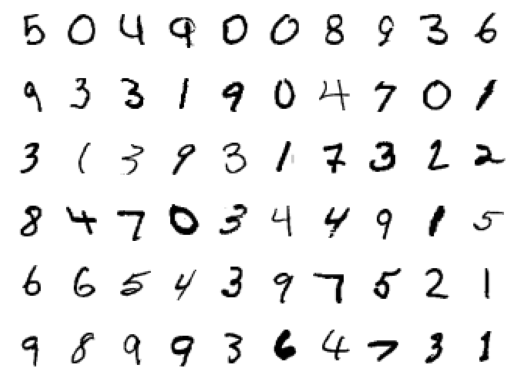

In [69]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

figure = plt.figure()
for i in range(1, 61):
    plt.subplot(6, 10, i)
    plt.axis('off')
    plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')

In [70]:
input_size = 784
output_size = 10

model = nn.Sequential(nn.Linear(input_size, output_size), nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=10, bias=True)
  (1): LogSoftmax(dim=1)
)


In [71]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [72]:
USE_GPU = False if torch.cuda.is_available() else False
device = torch.device("cuda:1" if USE_GPU else "cpu")
print('Using', device)

# model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

time0 = time()
for i in range(int(30)):
    rloss = 0
    for images, labels in trainloader:
        # -- Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1) # .to(device)
        # labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images) #.to(device)
        loss = criterion(output, labels) #.to(device)
        
        # -- This is where the model learns by backpropagating
        loss.backward()

        # -- And optimizes its weights here
        optimizer.step()
        rloss += loss.item()
    print("Epoch {} - Training loss: {}".format(i, rloss/len(trainloader)))
    
time1 = time()
print('time elapsed', time1 - time0, 'sec')

Using cpu
Epoch 0 - Training loss: 0.46946805885542175
Epoch 1 - Training loss: 0.33251259896133756
Epoch 2 - Training loss: 0.3126714376133007
Epoch 3 - Training loss: 0.30187697392473345
Epoch 4 - Training loss: 0.2961028219857958
Epoch 5 - Training loss: 0.29012842166986164
Epoch 6 - Training loss: 0.2861081006478018
Epoch 7 - Training loss: 0.2841466296631009
Epoch 8 - Training loss: 0.2808725595482186
Epoch 9 - Training loss: 0.2794664053043831
Epoch 10 - Training loss: 0.27732533214093524
Epoch 11 - Training loss: 0.2756165432602739
Epoch 12 - Training loss: 0.27315242594080186
Epoch 13 - Training loss: 0.27208490764249615
Epoch 14 - Training loss: 0.27172913700977624
Epoch 15 - Training loss: 0.2695994724525508
Epoch 16 - Training loss: 0.269281971250484
Epoch 17 - Training loss: 0.267648248863754
Epoch 18 - Training loss: 0.2666164358009471
Epoch 19 - Training loss: 0.2662835134419678
Epoch 20 - Training loss: 0.26476732214916743
Epoch 21 - Training loss: 0.2637286431221629
Epo

In [73]:
cnt = 0
tot = 0
model = model.to(torch.device('cpu'))

for image, value in valloader:
    for i in range(len(value)):
        img = image[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)

        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred = probab.index(max(probab))
        t = value.numpy()[i]
        if pred == t:
            cnt += 1
        tot += 1

acc = cnt/tot
print("Correct: ", cnt)
print("Total: ", tot)
print("Accuracy: ", acc)

Correct:  9225
Total:  10000
Accuracy:  0.9225


64 64
Predicted Digit = 6 vs tensor(6)
tensor([[2.1936e-07, 5.6126e-12, 4.9927e-05, 2.9011e-08, 1.7390e-02, 1.3666e-08,
         9.8249e-01, 2.7735e-05, 5.1904e-06, 3.6727e-05]])


[Text(0.5, 0, 'digits'), Text(0, 0.5, 'probability')]

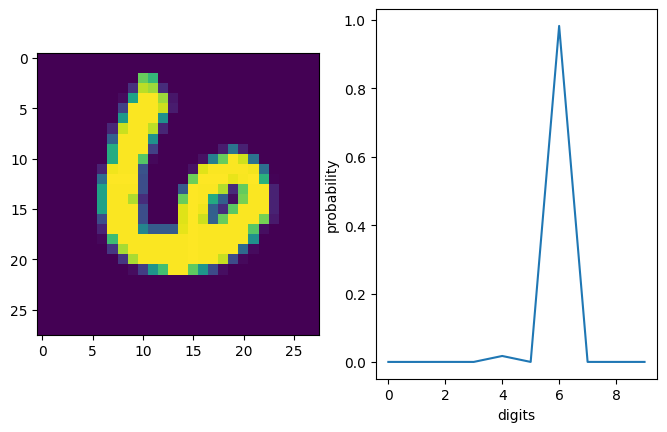

In [99]:
images, labels = next(iter(valloader))

print(len(images), len(labels))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)), 'vs', labels[0])
print(ps)

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(8)
ax[0].imshow(img.view(28, 28))
ax[1].plot(np.arange(10), ps.view(10))
ax[1].set(xlabel ='digits', ylabel ='probability')

In [96]:
torch.save(model, './lab3_mnist_model.pt')